# Stochastic Simulation Algorithm
In class, we studied the reaction network
$$A + B -> 2B$$
$$B -> A$$

with $k_1$ as the stochastic constant for the first reaction and $k_2$ as the stochastic constant for the second reaction.

We let $m$ be the number of $A$ molecules and we let $n$ be the number of $B$ molecules.

The propensity of reaction 1 is $a_1=k_1mn$ and the propensity of reaction 2 is $a_2=k_2n$.

We considered how we could leave the state $(m,n)$ and how we could arrive at the state $(m,n)$:

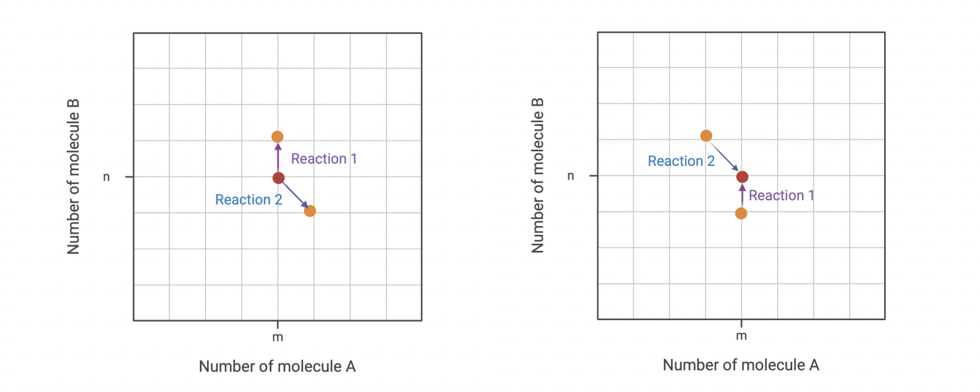






We derived the Chemical Master Equation (CME) for this network and found it to be
$$\frac{dP}{dt} = P(m,n,t)(-k_1mn-k_2n)+P(m-1,n+1,t)k_2(n-1)$$

The CME is usually not tractable to solve analytically, but we can sample trajectories of the chemical reaction network characterized by the CME by applying the SSA (Gillespie, 1977).


Our process will be:
1. Set the initial state $\bf{N}$ (number of molecules of A and of B)
2. Calculate the reaction propensities $a_k$.  Note: the propensities depend on the state so have to be calculated at each iteration.
3. Determine the reaction.  Draw a sample $R_k$ from the random variable $R$ to determine which reaction will fire.  (Test the random number with the inequalities which determine of the possible cases fires.)
4. Determine the time at which the reaction occurs.  Draw a sample $\tau$ from the random variable $T$, assuming exponential waiting time.
5. Increment the simulation time $t$ to $t+\tau$
6. Update the state vector $\bf{N}$ to $\bf{N} + \bf{S_k}$ to reflect the fact that reaction $k$ has occured.
7. Return to step 2.

We will continue until the simulation time $t$ reaches the end of a speficied time interval.

Note: in Step 6, $\bf{S_k}$ is a vector which indicates what molecules are added or lost due to the reaction.  For our reaction network, $\bf{S_1} = (0,1)$ because the reaction $A + B -> 2B$ has no change in $A$ and an addition of a molecule $B$.  For this network, $\bf{S_2}=(1,-1)$ because $B -> A$ means one molecure of $B$ is lost and one molecule of $A$ is gained.  This vector is called a *stoichiometry vector*, and is used for bookkeeping between the reaction equations and state updates.  It encodes how much of each species are consumed or produced.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
# for reproducibility, you can set a seed if you want with the line below
# once you set a seed, the sequence of random numbers will be deterministic and reproduce
# random.seed(42) # pick any integer

### Setup and Initial State
We need to set the parameters for the reactions, the ensemble size (how many samples we want to generate), and the number of time steps we want to simulate per trajectory.  We also need to set initial conditions (how many of each molecule we start with).

In [2]:
# --- Parameters ---
k1 = 0.02   # rate for A + B -> A + 2B
k2 = 0.5    # rate for B -> A

N  = 3      # ensemble size (how many samples we want to generate)
Tsteps = 50 # number of reaction events (steps) to simulate per trajectory

# --- Initial conditions ---
A0 = 5      # start with 5 molecues of A
B0 = 10     # start with 10 molecues of B

### Storage 
We need to set up data storage arrays (matrices) for the simulation so every trajectory has its molecule counts at each time step. The rows are the time steps, and the columns are each ensemble member (each trajectory) with total ensemble size $N$.
`A[2,0]=6` means in trajectory 1 (Python index starts at 0), after step 2, there are 6 molecules of $A$.  
(the reason the row index is not offset is because the row index 0 has the initial condition before any reaction, row index one is after the first reaction, etc.).
Note that the actual time the reaction happens is stored separately (we have to determine that). 
The include the initial conditions in these storage arrays.

In [3]:
# --- Storage: rows = step index (including step 0), cols = ensemble member ---
A = np.zeros((Tsteps, N), dtype=int) # molecule counts are integers
B = np.zeros((Tsteps, N), dtype=int)
t = np.zeros((Tsteps, N), dtype=float) # times of reaction are floats

A[0, :] = A0
B[0, :] = B0
t[0, :] = 0.0

### SSA
- the outer loop loops over each ensemble member (trajectory) separately (there are $N$)
- the inner loop loops over the reaction events for this trajectory (the $j^{th}$), moving through time
- we get the current state, $nA$ and $nB$.  We will need this to calculate the propensities
- we calculate the propensities $a_1$ and $a_2$
- we need the total propensity `atot`, $\sum_{i=1}a_i$ to calculate the time of next firing
- the test `atot<=0` ensures we continue only if reactions are still possible.  For example, if the number of $B$ molecules becomes zero in our reaction network, not reactions can take place (no matter how many molecules of $A$ exist).

### Determine what reaction will fire
Here we draw a random number $U$ to select the reaction.  If it is less than $\frac{a_1}{a_{tot}}$, Reaction 1 fires.  Otherwise, Reaction 2 fires.  In either case, we have to update the molecule numbers.  Reaction 1 leaves the number of $A$ unchanged and adds one molecule of $B$, and reaction 2 increases $A$ by one and decreases $B$ by one.

(Note: In reaction networks with more than two reactions, you will need to break down the different cases so it will not just be an `if` and `else`. Python uses `elif` if you need more than 2 conditions.)

### Determine when the next reaction will happen
We sample from an exponential random variable, $f(\tau) = a_{tot}e^{{-a_{tot}} \tau}$, $\tau \geq 0$.  We can use the `random.exponential(scale, size)` function from the NumPy library to sample. In this, the parameter `scale` is $\frac{1}{a_{tot}}$ for our problems.  (For a general exponential, it is $\frac{1}{\lambda}$).  The `size` argument is optional.   This information can be found by looking at the NumPy [documentation](https://numpy.org/doc/2.1/reference/random/generated/numpy.random.exponential.html).

We then need to update the clock by incrementing time by $\tau$.

### Finish for the time period for the trajectory
This means finish the inner loop with counter $i$.

### Repeat for all trajectories
This means finish the outer loop with counter $j$.

### Guards
We have a few things in here we have to guard against: 
- if the molecule count of A or B becomes zero then reaction 1 can't occur.  If the molecule count of B becomes zero, then reaction 2 can't occur.  It doesn't make sense to have negative molecule counts.  We have a guard for this in the code below.
- if the total propensity becomes zero, no reaction can occur.  We would also not want to divide by zero (recall we divide by the total propensity to partition our unit interval).  Because propensities are calculated with floating point math, which can can accumulate round-off error, it is common to set a threshold that so any numerical noise near zero is treated as zero.  (The name `EPS` is shorthand for epsilon, which you know from math classes usually represents a very small number).



In [4]:
 # --- Gillespie SSA over the ensemble ---
EPS = 1e-15  # tiny guard against numerical zero

for j in range(N):  # loop through trajectories
    for i in range(Tsteps - 1):  # loop through events
        nA, nB = A[i, j], B[i, j] # get number of A and number of B

        # propensities given current state 
        a1 = k1 * nA * nB   # A+B -> A+2B (B +1)
        a2 = k2 * nB        # B -> A     (A +1, B -1)
        atot = a1 + a2      # total propensity

        # if no reactions are possible, freeze the rest of this trajectory
        if atot <= EPS:
            A[i+1:, j] = nA
            B[i+1:, j] = nB
            t[i+1:, j] = t[i, j]
            break

        # --- choose which reaction fires ---
        p1 = a1 / atot         # safe because atot > EPS
        u  = random.random()   # U ~ Uniform(0,1)

        if u < p1:
            # Reaction 1: A+B -> A+2B  (A same, B increases by 1)
            A[i+1, j] = nA
            B[i+1, j] = nB + 1
        else:
            # Reaction 2: B -> A  (A +1, B -1; guard at zero)
            A[i+1, j] = nA + 1
            B[i+1, j] = max(nB - 1, 0) # don't let molecule count become negative

        # --- draw waiting time to next reaction ---
        tau = np.random.exponential(1 / atot)  # Exp(atot)
        t[i+1, j] = t[i, j] + tau


### Plot our trajectories in the ensemble
- This creates 2 side-by-side subplots (it's a figure with 1 row and 2 columns-- that is what the `1, 2` mean).
- `figsize=(11,4)` controls the size.
- `constrained_layout=True'` makes sure labels/titles don't overlap
- We loop over all simulation runs $N$
- We make a step-plot because the counts change at discrete reaction times
- `lw=11` sets line width and `alpha=0.8` sets transparency (this is not a parameter in our equations)
- Each run plots its own curve, and we get a "spaghetti plot" of all trajectories.
- We set the limits on the $x$-axis by finding the max simulation time across all runs
- We set the $y$-axis to start at $0$ because there will molecule counts have to be greater than or equal to zero.
- We label the plots, and then show the figure.


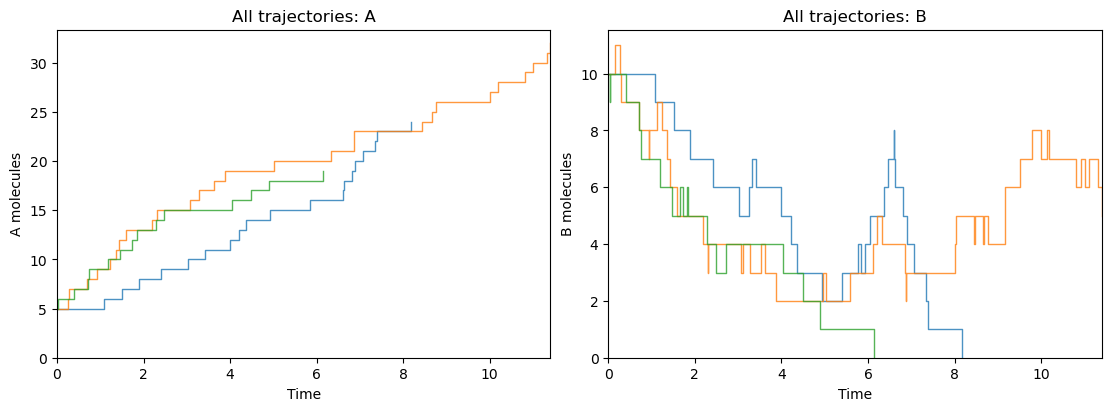

In [5]:
# --- Plot ALL trajectories  ---
fig, (axA_all, axB_all) = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

for j in range(N):
    axA_all.step(t[:, j], A[:, j], where='post', lw=1, alpha=0.8)
    axB_all.step(t[:, j], B[:, j], where='post', lw=1, alpha=0.8)

# nice axes (use ensemble-wide max time)
tmax_all = np.max(t)
axA_all.set_xlim(0, tmax_all); axB_all.set_xlim(0, tmax_all)
axA_all.set_ylim(bottom=0);    axB_all.set_ylim(bottom=0)

axA_all.set_xlabel('Time'); axA_all.set_ylabel('A molecules'); axA_all.set_title('All trajectories: A')
axB_all.set_xlabel('Time'); axB_all.set_ylabel('B molecules'); axB_all.set_title('All trajectories: B')

plt.show()


### Compute and plot ensemble means

### Build our common time grid
Remember, we did not predetermine the time grid (like we do when numerically solving ODEs).  The time grid is determined by the sampling of $\tau$. This sampling is likely different for each trajectory.

The code below takes all the event times from $\bf{every}$ trajectory and combines them into one timeline so we can compare average trajectories at the same time points.  (I did not code this from scratch and upcycled info online.)

Some notes on the code below to explain it (you do not have to know this and there are alternative ways to achieve this):
- `t[:,j]` is the time array for the $(j-1)^{th}$ trajectory (all rows for column $j$-- remember Python indexing starts at $0$)
- `[t[:, j] for j in range(N)]` collects the time array for each trajectory (one array per trajectory).  
- `np.concatenate([])`stitches those arrays together into one long 1D array which has all event times from all trajectories (for each trajectory the times are increasing but between trajectories they are unrelated-- they are not ordered globally yet)
- `np.unique()` sorts the array in ascending order and avoids duplicates
- `time_grid[-1]` takes the last element from this long sorted array (useful for setting x-axis limits)

In [6]:
# --- Build a common event-time grid (union of all event times) ---
time_grid = np.unique(np.concatenate([t[:, j] for j in range(N)])) # j is trajectory index
tmax = time_grid[-1] # index takes last item

In [7]:
def step_eval(times, values, grid):
    """Right-continuous (post) stepwise evaluation on a common grid."""
    idx = np.searchsorted(times, grid, side='right') - 1
    idx = np.clip(idx, 0, len(times) - 1)
    return values[idx]

# --- Ensemble means on the common grid ---
A_mean = np.zeros_like(time_grid, dtype=float)
B_mean = np.zeros_like(time_grid, dtype=float)
for j in range(N):
    A_mean += step_eval(t[:, j], A[:, j], time_grid)
    B_mean += step_eval(t[:, j], B[:, j], time_grid)
A_mean /= N
B_mean /= N



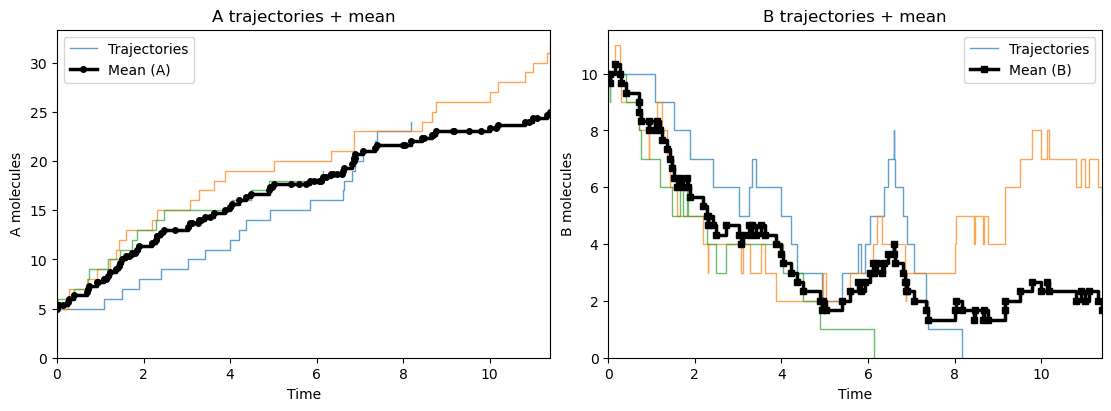

In [8]:
# --- Plot all trajectories + overlay means ---
fig, (axA, axB) = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

# individual trajectories (color coded)
for j in range(N):
    axA.step(t[:, j], A[:, j], where='post', lw=1, alpha=0.7,
             label='Trajectories' if j == 0 else None)
    axB.step(t[:, j], B[:, j], where='post', lw=1, alpha=0.7,
             label='Trajectories' if j == 0 else None)

# overlay ensemble mean (thicker + markers)
axA.step(time_grid, A_mean, where='post', lw=2.5, marker='o', markersize=4,
         color='black', label='Mean (A)')
axB.step(time_grid, B_mean, where='post', lw=2.5, marker='s', markersize=4,
         color='black', label='Mean (B)')

axA.set_xlabel('Time')
axA.set_ylabel('A molecules')
axA.set_title('A trajectories + mean')

axB.set_xlabel('Time')
axB.set_ylabel('B molecules')
axB.set_title('B trajectories + mean')

axA.set_xlim(0, tmax) # using tmax to set bound
axB.set_xlim(0, tmax)
axA.set_ylim(bottom=0)
axB.set_ylim(bottom=0)

axA.legend(loc='best')
axB.legend(loc='best')

plt.show()


### Tasks to Try
1. I ran only a few trajectories (3) in my ensemble just to make sure everything looked like it was working.  Change the ensemble size to something larger.  Do you see trajectories that seem like outliers?  Do some trajectories have a species go extinct?
2. For the same reaction system, write a compartment model for the concentrations of $A$ and $B$. (That is, a system of 2 ODEs, one for each concentration.)  Plot the solution using $k_1=.02$, $k_2=.5$, and initial condition $A(0)=5$, $B(0)=10$.  (For simplicity, assume we have one unit of volume so we can compare the two frameworks without scaling.)  
3. We previously studied the SIR model in a deterministic framework.  Recast this into a stochastic framework and alter the code above to use the SSA for the SIR model.  It is enough to track just $S$ and $I$ and the two reactions you consider will be infection and recovery.  Let the stochastic transmission parameter be $\alpha=.2$ and the stochastic recovery parameter be $\beta=.01$, and let the initial condition be $S(0)=90$, $I(0)=10$.
4. Consider the SIR model but now with vaccination (moving a susceptible directly into the recovered compartment.  Let the stochastic rate constant for vaccination be $\nu=.05$.  Repeat the problem from above with the same initial conditions and parameter values.  (Hint: much will be the same, but now instead of choosing from 2 reactions, you will choose from 3.)
5. Experiment with the above model by changing $\nu$.  Does it seem that at a certain value, the infection almost always dies out early?